# Predicting Flight Arrival Delays
## By Nick Palacio

### Constants

In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
import utils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import AdaBoostRegressor

In [50]:
flightDataFile = './Flight Delays Data.csv'
weatherDataFile = './Weather Data.csv'
# depDelayCol = 'DepDelay'
# arrDelayCol = 'ArrDelay'
# carrierCol = 'Carrier'
# originAirportCol = 'OriginAirportID'
# monthCol = 'Month'
# dayCol = 'DayOfWeek'

### Load Data

In [51]:
# TODO: Undo this
flightData = pd.read_csv(flightDataFile, nrows=1000)
# data = pd.read_csv(flightDataFile)
flightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,4,19,5,DL,11433,13303,837,-3.0,0.0,1138,1.0,0.0,0.0
1,2013,4,19,5,DL,14869,12478,1705,0.0,0.0,2336,-8.0,0.0,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0,0.0,851,-15.0,0.0,0.0
3,2013,4,19,5,DL,15016,11433,1630,28.0,1.0,1903,24.0,1.0,0.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0,0.0,1805,-11.0,0.0,0.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0,0.0,1818,-19.0,0.0,0.0
6,2013,4,19,5,DL,15016,10397,1900,0.0,0.0,2133,-1.0,0.0,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0,1.0,2356,24.0,1.0,0.0
8,2013,4,19,5,DL,10397,10423,2157,33.0,1.0,2333,34.0,1.0,0.0
9,2013,4,19,5,DL,11278,10397,1900,323.0,1.0,2055,322.0,1.0,0.0


### Clean Data

#### Missing Data

In [52]:
utils.FillInMissingNumericValues(flightData,'DepDelay',0)
utils.FillInMissingNumericValues(flightData,'ArrDelay',0)
# flightData

Filled in 2 missing values for DepDelay
Filled in 2 missing values for ArrDelay


#### Duplicate Rows

In [53]:
utils.DropDuplicates(flightData,['Year','Month','DayofMonth','Carrier','OriginAirportID','DestAirportID','CRSDepTime','CRSArrTime'])
# flightData

Deleted 0 duplicate rows


#### Filter Columns

In [54]:
filteredFlightData = utils.FilterColumns(flightData, ['Year','Month','DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','CRSDepTime','DepDelay'])
filteredFlightData

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay
0,2013,4,19,5,DL,11433,13303,837,-3.0
1,2013,4,19,5,DL,14869,12478,1705,0.0
2,2013,4,19,5,DL,14057,14869,600,-4.0
3,2013,4,19,5,DL,15016,11433,1630,28.0
4,2013,4,19,5,DL,11193,12892,1615,-6.0
5,2013,4,19,5,DL,10397,15016,1726,-1.0
6,2013,4,19,5,DL,15016,10397,1900,0.0
7,2013,4,19,5,DL,10397,14869,2145,15.0
8,2013,4,19,5,DL,10397,10423,2157,33.0
9,2013,4,19,5,DL,11278,10397,1900,323.0


#### Handle Categorical Data

In [75]:
pristineFlightData = pd.get_dummies(filteredFlightData,columns=['Carrier','OriginAirportID','DestAirportID'])
pristineFlightData.DepDelay.unique()

array([ -3.,   0.,  -4.,  28.,  -6.,  -1.,  15.,  33., 323.,  -7.,  22.,
        40.,  -2.,  71.,  75.,  31.,   8.,   7.,  13.,   4.,  12.,  56.,
        -5.,  21.,  16.,   2.,  34.,   5.,  -8.,  20.,  35.,   1.,  -9.,
         6.,   9., 103.,  10., 292.,  25., 129.,  76., 184.,  57., 138.,
       213.,  49., 183.,   3.,  18.,  19., 120., 255., 263.,  95., 945.,
        11.,  24.,  59., 110., 136.,  51., 205., 139.,  74.,  27.,  37.,
       -10.,  23., 392.,  17., 537., 113.,  14., 164.,  52.,  50., 132.,
        45.,  55.,  46., 198.,  36.,  38., 242., 128.,  53., 181., 174.,
        90., 230.,  26.,  78.,  61., 111.,  30.,  77.,  29.,  91., 273.,
        41., 303.,  39., 100.,  63.,  32.,  65.,  43.,  47., -11., 109.,
       116.,  42.,  44., 340.,  69.,  82.,  86., 197., 217.,  62.,  73.,
        70.,  92.,  48., 145.,  54., 175.,  60., 117.,  72., 127., 987.,
        85.,  98., -16.])

In [56]:
# pristineFlightData = pd.get_dummies(filteredFlightData,columns=['Carrier','OriginAirportID','DestAirportID'])
pristineFlightData.Year.unique()

array([2013], dtype=int64)

### Analyze Features

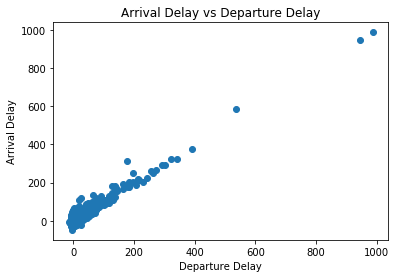

In [76]:
arrDelayData = flightData['ArrDelay']
depDelayData = flightData['DepDelay']
plt.scatter(depDelayData, arrDelayData)
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')
plt.title('Arrival Delay vs Departure Delay')
plt.show()

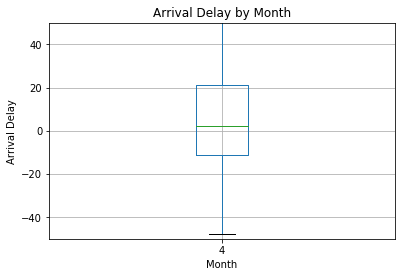

In [77]:
ax = flightData.boxplot('ArrDelay',by='Month',return_type=None)
ax.set_ylim(-50,50)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Month')
plt.title('Arrival Delay by Month')
plt.suptitle('')
plt.show()

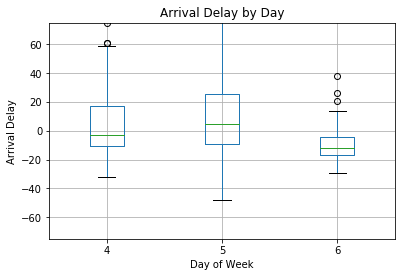

In [78]:
ax = flightData.boxplot('ArrDelay',by='DayOfWeek',return_type=None)
ax.set_ylim(-75,75)
plt.axes(ax)
plt.ylabel('Arrival Delay')
plt.xlabel('Day of Week')
plt.title('Arrival Delay by Day')
plt.suptitle('')
plt.show()

### Filter Columns

### Run Algorithms

In [97]:
mask = np.random.rand(len(pristineFlightData)) < .7
trainingDataX = pristineFlightData[mask]
testingDataX = pristineFlightData[~mask]
labelData = flightData.filter(items=['ArrDelay'])
trainingLabelData = labelData[mask]
testingLabelData = labelData[~mask]

In [98]:
comparisonDict = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

#### Linear Regression

In [99]:
linRegrModel = LinearRegression()
linRegrModel.fit(trainingDataX,trainingLabelData)
predictedLRLabelData = linRegrModel.predict(testingDataX)

In [100]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedLRLabelData)
# comparisonDict

#### Decision Tree Regression

In [101]:
dtModel = tree.DecisionTreeRegressor()
dtModel.fit(trainingDataX,trainingLabelData)
predictedDTLabelData = dtModel.predict(testingDataX)

In [102]:
comparisonDict = utils.UpdateComparisonDict(comparisonDict, testingLabelData, predictedDTLabelData)

#### Comparison

In [103]:
algorithms = ('LR', 'DT')
y_pos = np.arange(len(algorithms))

Text(0.5,1,'MAE by Algorithm')

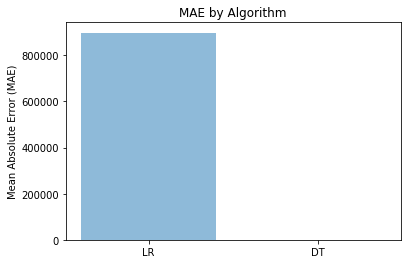

In [104]:
plt.bar(y_pos, comparisonDict['MeanAbsErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE by Algorithm')

Text(0.5,1,'MSE by Algorithm')

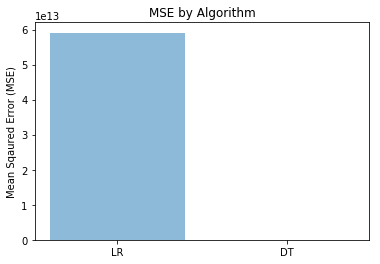

In [105]:
plt.bar(y_pos, comparisonDict['MeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Mean Sqaured Error (MSE)')
plt.title('MSE by Algorithm')

Text(0.5,1,'RMSE by Algorithm')

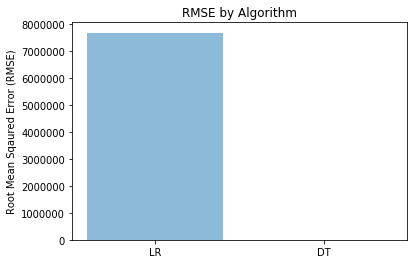

In [106]:
plt.bar(y_pos, comparisonDict['RootMeanSquErr'], align='center', alpha=0.5)
plt.xticks(y_pos, algorithms)
plt.ylabel('Root Mean Sqaured Error (RMSE)')
plt.title('RMSE by Algorithm')

### Introduce Weather Dataset

In [107]:
# weatherData = pd.read_csv(weatherDataFile,nrows=100)
weatherData = pd.read_csv(weatherDataFile)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'Visibility', ['M'], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'DryBulbCelsius', ['M'], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'WetBulbCelsius', ['M'], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'DewPointCelsius', ['M'], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'RelativeHumidity', ['M'], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'WindSpeed', ['M','  '], 0)
weatherData = utils.ConvertColumnToNumeric(weatherData, 'StationPressure', ['M'], 0)

C:\Users\Nick\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [137]:
# Add hour fields to join weather data with flight data
import utils
processedData['CRSDepHour'] = data.apply(lambda row: utils.CalculateFlightDataHour(row),axis=1)
# adjustedYear = weatherData.apply(lambda row: utils.CalculateWeatherDataYear(row),axis=1)
# adjustedMonth = weatherData.apply(lambda row: utils.CalculateWeatherDataMonth(row),axis=1)
# adjustedDay = weatherData.apply(lambda row: utils.CalculateWeatherDataDay(row),axis=1)
# adjustedHour = weatherData.apply(lambda row: utils.CalculateWeatherDataHour(row),axis=1)
# weatherData['Year'] = adjustedYear
# weatherData['Month'] = adjustedMonth
# weatherData['Day'] = adjustedDay
# weatherData['Hour'] = adjustedHour
# weatherData

#### Filter Columns

In [138]:
columns = ['AirportID','Year','Month','Day','Time','Hour','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure']
processedWeatherData = utils.FilterColumns(weatherData, columns)
# processedWeatherData

,AirportID,Year,Month,Day,Time,Hour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,14843,2013,3,31,56,20,-4,10.00,24.4,23.3,22.8,90.0,13.0,30.06
1,14843,2013,3,31,156,21,-4,10.00,24.4,22.5,21.7,85.0,10.0,30.05
2,14843,2013,3,31,256,22,-4,10.00,24.4,22.5,21.7,85.0,9.0,30.03
3,14843,2013,3,31,356,23,-4,10.00,24.4,22.2,21.1,82.0,9.0,30.02
4,14843,2013,4,1,456,0,-4,10.00,24.4,22.2,21.1,82.0,7.0,30.03
5,14843,2013,4,1,556,1,-4,10.00,24.4,21.8,20.6,79.0,7.0,30.04
6,14843,2013,4,1,656,2,-4,10.00,25.0,21.7,20.0,74.0,9.0,30.07
7,14843,2013,4,1,756,3,-4,10.00,26.1,22.4,20.6,72.0,13.0,30.09
8,14843,2013,4,1,856,4,-4,10.00,27.8,22.9,20.6,65.0,14.0,30.11
9,14843,2013,4,1,956,5,-4,10.00,28.3,23.0,20.6,63.0,16.0,30.11


#### Drop Duplicate Weather Records

In [89]:
utils.DropDuplicates(processedWeatherData, ['AirportID','Year','Month','Day','Hour'])

Deleted 0 duplicate rows


#### Join with Weather Dataset

In [142]:
# mergedData = processedData.merge(processedWeatherData,how='left', left_on=['OriginAirportID','Year','Month','DayofMonth','CRSDepHour'], right_on=['AirportID','Year','Month','Day','Hour'])
# mergedData
mergedData.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepDelay',
       'CRSDepHour', 'TimeZone', 'Visibility', 'DryBulbCelsius',
       'WetBulbCelsius', 'DewPointCelsius', 'RelativeHumidity', 'WindSpeed',
       'StationPressure'],
      dtype='object')

#### Drop Columns

In [143]:
columns = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier','OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepDelay','CRSDepHour','ArrDelay','TimeZone','Visibility','DryBulbCelsius','WetBulbCelsius','DewPointCelsius','RelativeHumidity','WindSpeed','StationPressure']
mergedData = utils.FilterColumns(mergedData, columns)
utils.FillInMissingNumericValues(mergedData, 'TimeZone',0)
utils.FillInMissingNumericValues(mergedData, 'Visibility',0)
utils.FillInMissingNumericValues(mergedData, 'DryBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'WetBulbCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'DewPointCelsius',0)
utils.FillInMissingNumericValues(mergedData, 'RelativeHumidity',0)
utils.FillInMissingNumericValues(mergedData, 'WindSpeed',0)
utils.FillInMissingNumericValues(mergedData, 'StationPressure',0)
mergedData

Filled in 0 missing values for TimeZone
Filled in 0 missing values for Visibility
Filled in 0 missing values for DryBulbCelsius
Filled in 0 missing values for WetBulbCelsius
Filled in 287341 missing values for DewPointCelsius
Filled in 0 missing values for RelativeHumidity
Filled in 287341 missing values for WindSpeed
Filled in 0 missing values for StationPressure


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSDepHour,TimeZone,Visibility,DryBulbCelsius,WetBulbCelsius,DewPointCelsius,RelativeHumidity,WindSpeed,StationPressure
0,2013,4,19,5,DL,11433,13303,837,-3.0,8,-5.0,10.0,6.1,3.1,-1.1,60.0,34.0,28.89
1,2013,4,19,5,DL,14869,12478,1705,0.0,17,-7.0,10.0,7.8,6.6,5.6,86.0,0.0,25.71
2,2013,4,19,5,DL,14057,14869,600,-4.0,6,-8.0,10.0,13.9,11.5,9.4,75.0,9.0,30.09
3,2013,4,19,5,DL,15016,11433,1630,28.0,16,-6.0,10.0,5.6,1.8,-3.9,51.0,7.0,29.31
4,2013,4,19,5,DL,11193,12892,1615,-6.0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5,2013,4,19,5,DL,10397,15016,1726,-1.0,17,-5.0,10.0,7.8,5.5,2.8,71.0,10.0,28.95
6,2013,4,19,5,DL,15016,10397,1900,0.0,19,-6.0,10.0,3.9,1.2,-2.8,62.0,6.0,29.35
7,2013,4,19,5,DL,10397,14869,2145,15.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
8,2013,4,19,5,DL,10397,10423,2157,33.0,21,-5.0,10.0,5.6,3.2,0.0,68.0,13.0,28.97
9,2013,4,19,5,DL,11278,10397,1900,323.0,19,-5.0,10.0,11.7,9.4,7.2,74.0,8.0,29.75


#### Handle Categorical Data

In [144]:
mergedData = pd.get_dummies(mergedData,columns=['Carrier','OriginAirportID','DestAirportID','TimeZone'])
mergedData.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'DepDelay',
       'CRSDepHour', 'Visibility', 'DryBulbCelsius', 'WetBulbCelsius',
       ...
       'DestAirportID_15304', 'DestAirportID_15376', 'TimeZone_-10.0',
       'TimeZone_-9.0', 'TimeZone_-8.0', 'TimeZone_-7.0', 'TimeZone_-6.0',
       'TimeZone_-5.0', 'TimeZone_-4.0', 'TimeZone_0.0'],
      dtype='object', length=178)

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor

In [146]:
import numpy as np
mask = np.random.rand(len(mergedData)) < .7
trainingDataX = mergedData[mask]
testingDataX = mergedData[~mask]
labelData = data.filter(items=['ArrDelay'])
trainingLabelData = labelData[mask]
testingLabelData = labelData[~mask]

In [152]:
comparisonDict = {
    'MeanAbsErr': [],
    'MeanSquErr': [],
    'RootMeanSquErr': []
}

#### Linear Regression

In [153]:
linRegrModel = LinearRegression()
linRegrModel.fit(trainingDataX,trainingLabelData)
predictedLRLabelData = linRegrModel.predict(testingDataX)

In [154]:
comparisonDict['MeanAbsErr'].append(metrics.mean_absolute_error(testingLabelData, predictedLRLabelData))
comparisonDict['MeanSquErr'].append(metrics.mean_squared_error(testingLabelData, predictedLRLabelData))
comparisonDict['RootMeanSquErr'].append(np.sqrt(metrics.mean_squared_error(testingLabelData, predictedLRLabelData)))

print('Mean Absolute Error:', metrics.mean_absolute_error(testingLabelData, predictedLRLabelData))
print('Mean Squared Error:', metrics.mean_squared_error(testingLabelData, predictedLRLabelData))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testingLabelData, predictedLRLabelData)))

Mean Absolute Error: 8.792024510544708
Mean Squared Error: 166.8624228743075
Root Mean Squared Error: 12.917523867766125


In [151]:
labelData

,ArrDelay
0,1.0
1,-8.0
2,-15.0
3,24.0
4,-11.0
5,-19.0
6,-1.0
7,24.0
8,34.0
9,322.0
